<a href="https://colab.research.google.com/github/sfoucher/Masterclass-Biodiversity/blob/code-reorg/code/jupyter_notebooks/fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to perform training procedure as described in "*Multispecies detection and identification of African mammals in aerial imagery using CNN*"


---
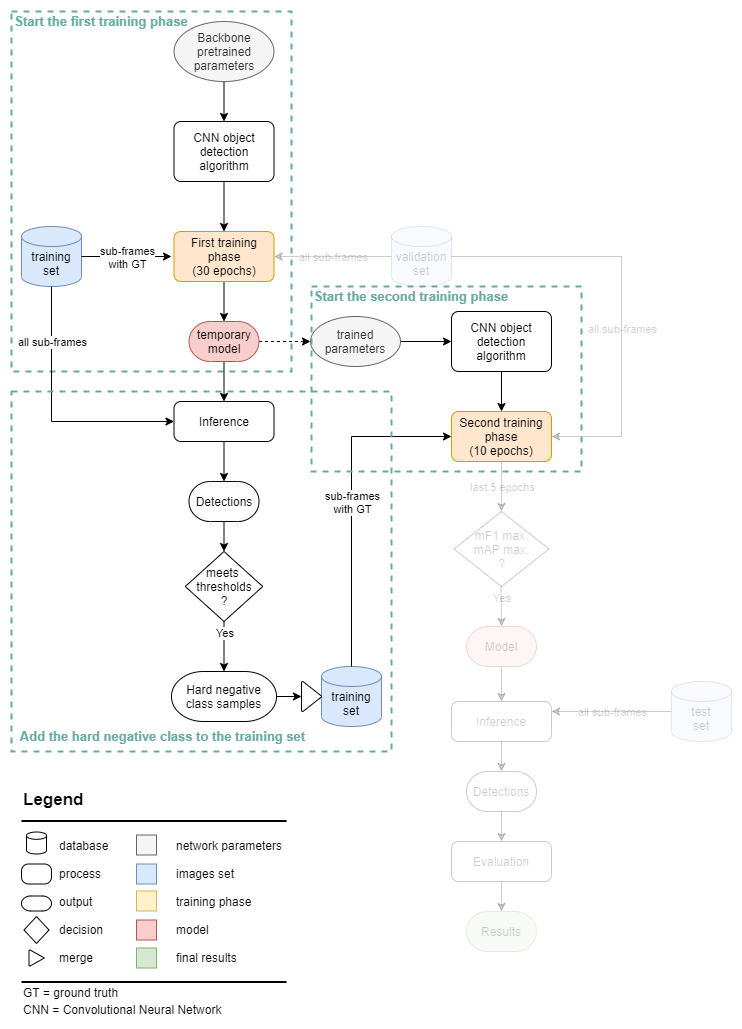



# Fill with your paths

In [2]:
!gdown --id 1xx9BAvC_-8DgROSELUqty_QK_ch4DSd9 -O general_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1xx9BAvC_-8DgROSELUqty_QK_ch4DSd9
To: /misc/home/visi/fouchesa/projets/notebooks/jupyter_notebooks/general_dataset.zip
100%|██████████████████████████████████████| 13.2G/13.2G [10:08<00:00, 21.6MB/s]


In [ ]:
!unzip -oq /content/general_dataset.zip -d /content

In [3]:
!gdown --id 1raU3uP7F_dimq5d9TTSSAkD3vNXpvulf -O sub_frames_1000.zip

Downloading...
From: https://drive.google.com/uc?id=1raU3uP7F_dimq5d9TTSSAkD3vNXpvulf
To: /misc/home/visi/fouchesa/projets/notebooks/jupyter_notebooks/sub_frames_1000.zip
100%|██████████████████████████████████████| 1.46G/1.46G [01:02<00:00, 23.2MB/s]


In [3]:
!unzip -oq /content/sub_frames_1000.zip -d /content

In [4]:
!gdown --id 1N7h3uPRLyBFaP6q4LFUBOVJqPOQdNwgf -O sub_frames_500.zip

Downloading...
From: https://drive.google.com/uc?id=1N7h3uPRLyBFaP6q4LFUBOVJqPOQdNwgf
To: /misc/home/visi/fouchesa/projets/notebooks/jupyter_notebooks/sub_frames_500.zip
100%|██████████████████████████████████████| 1.21G/1.21G [00:51<00:00, 23.6MB/s]


In [53]:
!unzip -oq /content/sub_frames_500.zip -d /content

## Modify the config
In the next step, we need to modify the config for the training. To accelerate the process, we finetune a detector using a pre-trained detector.

Define a new dataset with the new classes:

Creating a new "my_datasets.py" file.

In [35]:
%%writefile /mmdetection/mmdet/datasets/my_dataset.py
# %%writefile /content/mmdetection/mmdet/datasets/my_dataset.py
from .builder import DATASETS
from .coco import CocoDataset

@DATASETS.register_module
class MyDataset(CocoDataset): 

	CLASSES = ('Alcelaphinae', 'Buffalo', 'Kob', 'Warthog', 'Waterbuck', 'Elephant')

Overwriting /mmdetection/mmdet/datasets/my_dataset.py


Overwriting the __init__.py file to adapt it.

In [36]:
%%writefile /mmdetection/mmdet/datasets/__init__.py
# %%writefile /content/mmdetection/mmdet/datasets/__init__.py
# Copyright (c) OpenMMLab. All rights reserved.
from .builder import DATASETS, PIPELINES, build_dataloader, build_dataset
from .cityscapes import CityscapesDataset
from .coco import CocoDataset
from .coco_panoptic import CocoPanopticDataset
from .custom import CustomDataset
from .dataset_wrappers import (ClassBalancedDataset, ConcatDataset,
                               MultiImageMixDataset, RepeatDataset)
from .deepfashion import DeepFashionDataset
from .lvis import LVISDataset, LVISV1Dataset, LVISV05Dataset
from .samplers import DistributedGroupSampler, DistributedSampler, GroupSampler
from .utils import (NumClassCheckHook, get_loading_pipeline,
                    replace_ImageToTensor)
from .voc import VOCDataset
from .wider_face import WIDERFaceDataset
from .xml_style import XMLDataset
from .my_dataset import MyDataset


__all__ = [
    'CustomDataset', 'XMLDataset', 'CocoDataset', 'DeepFashionDataset',
    'VOCDataset', 'CityscapesDataset', 'LVISDataset', 'LVISV05Dataset',
    'LVISV1Dataset', 'GroupSampler', 'DistributedGroupSampler',
    'DistributedSampler', 'build_dataloader', 'ConcatDataset', 'RepeatDataset',
    'ClassBalancedDataset', 'WIDERFaceDataset', 'DATASETS', 'PIPELINES',
    'build_dataset', 'replace_ImageToTensor', 'get_loading_pipeline',
    'NumClassCheckHook', 'CocoPanopticDataset', 'MultiImageMixDataset', 'MyDataset'
]

Overwriting /mmdetection/mmdet/datasets/__init__.py


Define the data pipeline and the model:

In [37]:
config_file = "/CRIM_notebooks/jupyter_notebooks/config2.py"
# config_file = '/content/Masterclass-Biodiversity/jupyter_notebooks/config2.py'

In [38]:
%%writefile /CRIM_notebooks/jupyter_notebooks/config2.py
# %%writefile /content/Masterclass-Biodiversity/jupyter_notebooks/config2.py

# Setting the base model to use.
_base_ = "/mmdetection/configs/libra_rcnn/libra_faster_rcnn_r101_fpn_1x_coco.py"
# _base_ = '/content/mmdetection/configs/libra_rcnn/libra_faster_rcnn_r101_fpn_1x_coco.py'

# Setting the number of classes to be analysed by the chosen model.
model = dict(
    roi_head = dict(
        bbox_head = dict(
            num_classes = 6  #TODO: Remove hard coded values.
        )
    )
)

# Setting the name and paths of the dataset.
dataset_type = "MyDataset"
data_root = "/general_dataset/sub_frames_500/"
# data_root = "/content/sub_frames/"
annot_root = data_root

# Setting the size of the previously created subframes.
tile_size = (500, 500)  #TODO: Remove hard coded values.
# tile_size= (1000,1000)

# Setting the image configuration TODO: Verify this section of the script.
img_norm_cfg = dict(
    mean = [123.675, 116.28, 103.53],
    std = [58.395, 57.12, 57.375],
    to_rgb = True
)

# Setting data augmentation parameters with the "albumentations" Python module for the training dataset. TODO: Verify this section of the script.
albu_train_transforms = [
    dict(
        type = "VerticalFlip",
        p = 0.5
    ),
    dict(
        type = "HorizontalFlip",
        p = 0.5
    ),
    dict(
        type = "RandomRotate90",
        p = 0.5
    ),
    dict(
        type = "RandomBrightnessContrast",
        brightness_limit = 0.2,
        contrast_limit = 0.2,
        p = 0.2
    ),
    dict(
        type = "Blur",
        blur_limit = 15,
        p = 0.2
    )
]

# Setting the pipeline for the training dataset.
train_pipeline = [
    dict(
        type = "LoadImageFromFile"
    ),
    dict(
        type = "LoadAnnotations",
        with_bbox = True
    ),
    dict(
        type = "Resize",
        img_scale = tile_size,
        keep_ratio = True
    ),
    # The following information are the "albu_train_transforms" variable.
    dict(
        type = "Albu",
        transforms = [
            dict(
                type = "VerticalFlip",
                p = 0.5
            ),
            dict(
                type = "HorizontalFlip",
                p = 0.5
            ),
            dict(
                type = "RandomRotate90",
                p = 0.5
            ),
            dict(
                type = "RandomBrightnessContrast",
                brightness_limit = 0.2,
                contrast_limit = 0.2,
                p = 0.2
            ),
            dict(
                type = "Blur",
                blur_limit = 15,
                p = 0.2
            )
        ],
        bbox_params = dict(
            type = "BboxParams",
            format = "pascal_voc",
            label_fields = [
                "gt_labels"
            ],
            min_visibility = 0.0
        ),
        keymap = dict(
            img = "image",
            gt_bboxes = "bboxes"
        ),
        update_pad_shape = False,
        skip_img_without_anno = True
    ),
    # The following information are the "img_norm_cfg" variable.
    dict(
        type = "Normalize",
        mean = [123.675, 116.28, 103.53],
        std = [58.395, 57.12, 57.375],
        to_rgb = True
    ),
    dict(
        type = "Pad",
        size_divisor = 32
    ),
    dict(
        type = "DefaultFormatBundle"
    ),
    dict(
        type = "Collect",
        keys = [
            "img",
            "gt_bboxes",
            "gt_labels"
        ],
        meta_keys = (
            "filename",
            "ori_shape",
            "img_shape",
            "img_norm_cfg",
            "pad_shape",
            "scale_factor"
        )
    )
]

# Setting the pipeline for the validation dataset.
val_pipeline = [
    dict(
        type = "LoadImageFromFile"
    ),
    dict(
        type = "MultiScaleFlipAug",
        img_scale = tile_size,
        flip = False,
        transforms = [
            dict(
                type = "Resize",
                keep_ratio = True
            ),
            dict(
                type = "RandomFlip"
            ),
            dict(
                type = "Normalize",
                mean = [123.675, 116.28, 103.53],
                std = [58.395, 57.12, 57.375],
                to_rgb = True
            ),
            dict(
                type = "Pad",
                size_divisor = 32
            ),
            dict(
                type = "ImageToTensor",
                keys = [
                    "img"
                ]
            ),
            dict(
                type = "Collect",
                keys = [
                    "img"
                ]
            )
        ]
    )
]

# Setting the pipeline for the testing dataset.
test_pipeline = [
    dict(
        type = "LoadImageFromFile"
    ),
    dict(
        type = "MultiScaleFlipAug",
        img_scale = tile_size,
        flip = False,
        transforms = [
            dict(
                type = "Resize",
                keep_ratio = True
            ),
            dict(
                type = "RandomFlip"
            ),
            dict(
                type = "Normalize",
                mean = [123.675, 116.28, 103.53],
                std = [58.395, 57.12, 57.375],
                to_rgb = True
            ),
            dict(
                type = "Pad",
                size_divisor = 32
            ),
            dict(
                type = "ImageToTensor",
                keys = [
                    "img"
                ]
            ),
            dict(
                type = "Collect",
                keys = [
                    "img"
                ]
            )
        ]
    )
]

# TODO: Verify this section of the script.
data = dict(
    samples_per_gpu = 2,
    workers_per_gpu = 4,
    train = dict(
        type = "MyDataset",
        ann_file = annot_root + "train/coco_subframes.json",
        img_prefix = data_root + "train",
        pipeline = train_pipeline
    ),
    val = dict(
        type = "MyDataset",
        ann_file = annot_root + "val/coco_subframes.json",
        img_prefix = data_root + "val",
        pipeline = val_pipeline
    ),
    test = dict(
        type = "MyDataset",
        ann_file = annot_root + "test/coco_subframes.json",
        img_prefix = data_root + "test",
        pipeline = test_pipeline
    )
)

# TODO: Verify this section of the script.
evaluation = dict(
    interval = 1,
    metric = "bbox"
)

# TODO: Verify this section of the script.
optimizer = dict(
    type = "SGD",
    lr = 0.001,
    momentum = 0.9,
    weight_decay = 0.001
)

# TODO: Verify this section of the script.
optimizer_config = dict(
    grad_clip = dict(
        _delete_ = True,
        max_norm = 35,
        norm_type = 2
    )
)

# TODO: Verify this section of the script.
lr_config = dict(
    policy = "step",
    warmup = "linear",
    warmup_iters = 100,
    warmup_ratio = 0.3333333333333333,
    step = [10, 20]
)

# TODO: Verify this section of the script.
checkpoint_config = dict(
    create_symlink = False,
    interval = 1
)

# TODO: Verify this section of the script.
log_config = dict(
    interval = 50,
    hooks = [
        dict(
            type = "TextLoggerHook"
        )
    ]
)

# TODO: Verify this section of the script.
runner = dict(
    type = "EpochBasedRunner",
    max_epochs = 12
)

# TODO: Verify this section of the script.
dist_params = dict(
    backend = "nccl"
)

# TODO: Verify this section of the script.
log_level = "INFO"

# TODO: Verify this section of the script.
work_dir = "./work_dirs/libra_faster_rcnn_r101_fpn_1x"

# TODO: Verify this section of the script.
load_from = None

# TODO: Verify this section of the script.
resume_from = None

# TODO: Verify this section of the script.
workflow = [
    ("train", 1)
]

# TODO: Verify this section of the script.
model_name = "libra-cnn"

# TODO: Verify this section of the script.
wnb_username = "sdurand"
# wnb_username = "sfoucher"

# TODO: Verify this section of the script.
#log_config = dict(interval=50,    hooks=[dict(type='TextLoggerHook'), dict(type='WandbLoggerHook')])
log_config = dict(
    interval = 50,
    hooks = [
        dict(
            type = "TextLoggerHook"
        ),
        dict(
            type = "WandbLoggerHook",
            init_kwargs = dict(
                project = "fine-tuning-libra-cnn",
                name = f'normalized {model_name}-workers{data["workers_per_gpu"]}samples/GPU{data["samples_per_gpu"]} lr {optimizer["lr"]}',
                config = {
                    "learning_rate": optimizer["lr"],
                    "architecture": "libra-cnn"
                },
                entity = wnb_username
            )
        )
    ]
)

Overwriting /CRIM_notebooks/jupyter_notebooks/config2.py


Check that the config file is valid

In [39]:
from mmcv import Config
print(config_file)
cfg = Config.fromfile( config_file)
#print(f'Config:\n{cfg.pretty_text}')
print("num_classes:",cfg.model.roi_head.bbox_head.num_classes)

/CRIM_notebooks/jupyter_notebooks/config2.py
num_classes: 6


In [40]:
# Models
models = {
    "faster_rcnn": {
        "config": "< path to the config file >",
        "out": "< path to your outputs folder >"
    },
    "libra_rcnn": {
        "config": f'{config_file}', #< path to the config file >
        "out": "/output"
        # "out": "/content/output"
    },
    "retinanet": {
        "config": "< path to the config file >",
        "out": "< path to your outputs folder >"
    }
}

seed = "516"

# Select your algorithm to train

In [41]:
# Which model ?
# ---
model_name = "libra_rcnn"
# ---

# Start the first training phase

In [43]:
# Develop MMDetection
mmdetection_dir = '/mmdetection'
# mmdetection_dir = '/content/mmdetection'
%cd {mmdetection_dir}
#!python setup.py develop
#!pip install -e {mmdetection_dir}

# Training
config_file = models[model_name]["config"]
print(config_file)
wd = models[model_name]["out"]
print(wd) 

!python tools/train.py $config_file \
--work-dir $wd \
--deterministic \
--seed $seed

/mmdetection
/CRIM_notebooks/jupyter_notebooks/config2.py
/output
/opt/conda/lib/python3.7/site-packages/mmcv/utils/registry.py:252: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '
/mmdetection/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/mmdetection/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS e

# Add the negative class to the training set

## 0) Add the checkpoints paths to your paths

In [ ]:
models[model_name]['checkpoint'] = '/content/output/epoch_20.pth'

## 1) Run the model on entire training images

In [ ]:
import pandas as pd
from mmdet.apis import init_detector
import time
import datetime
from datetime import date
import numpy as np
import os

# Initialize the model
model = init_detector(models[model_name]['config'], models[model_name]['checkpoint'])

# Initialize DataFrame
df = pd.DataFrame(columns=['Image','x1','y1','x2','y2','Label','Score'])

# Get images
images = os.listdir(images_folder)
if os.path.exists('/content/images_sub') is False:
    os.mkdir('/content/images_sub')

# Start inference on images
t_start = time.time()
for i,image in zip(range(len(images)),images):
    t_i = time.time()

    # Get predictions
    results = overlap_merging(
        img_path=os.path.join(images_folder,image),
        coco_path=original_size_annos,
        width=2000,
        height=2000,
        output_path='/content/images_sub',
        mmdet_model=model,
        IoU=0.5,
        sc_tresh=0.0
    )

    t_f = time.time()

    # Infos
    elapsed = str(datetime.timedelta(seconds=int(np.round(t_f-t_i))))
    print('Image [{}/{}] | Name : {} | Elapsed time : {}'
          .format(str(i+1), len(images), image, elapsed))

    if bool(results):
        for box , label , score in zip(results['boxes'],results['labels'],results['scores']):
            df = df.append(
                {'Image':image,
                'x1':box[0],
                'y1':box[1],
                'x2':box[2],
                'y2':box[3],
                'Label':label,
                'Score':score},
                ignore_index=True
            )
    # If no predictions, add a blank row
    else:
        df = df.append(
            {'Image':image,
            'x1':None,
            'y1':None,
            'x2':None,
            'y2':None,
            'Label':None,
            'Score':None}, 
            ignore_index = True
        )

# Export to CSV
outpath = os.path.join(models[model_name]['out'],f'{model_name}_{seed}_training_set_predictions.csv')
df.to_csv(outpath, index=False)

t_end = time.time()

# Print final infos
elapsed_total = str(datetime.timedelta(seconds=int(np.round(t_end-t_start))))
print('Total elapsed time : {}'.format(elapsed_total))

ModuleNotFoundError: ignored

## 2) Get the hard negative class samples and save a new annotations JSON file
Note that you should determine your score threshold to avoid class imbalance.

In [ ]:
# Score threshold
score_threshold = 0.50

# Open CSV file with predictions
preds = pd.read_csv(outpath)

# Open JSON file with ground truth
with open(original_size_annos) as j:
    gt = json.load(j)

# Matching
# ---
# Loop through gt
images = [i['file_name'] for i in gt['images']]
all_m = []
for img in images:
    # Get predictions
    p = preds[preds['Image']==img]
    # Matching
    m = match(p, img, original_size_annos, 0.3, with_scores=True)
    # Append to global list
    all_m.append(m)

# Concatenate global list
all_m = np.concatenate(all_m, axis=0)

# Make a dataframe
df_all_m = pd.DataFrame(
    {
        'gt': [m[0] for m in all_m],
        'pred': [m[1] for m in all_m],
        'iou': [m[2] for m in all_m],
        'score': [m[3] for m in all_m],
        'id': [m[4] for m in all_m]
    }
)

# Select IoU = 0 & score >= threshold
filtered_m = df_all_m[(df_all_m['iou']==0) & (df_all_m['score']>=score_threshold)]

# Make JSON annotation
# ---
preds_id = list(filtered_m['id'])
filtered_preds = pd.DataFrame([p for (i,p) in preds.iterrows() if i in preds_id])
new_gt = gt.copy()
last_ann_id = new_gt['annotations'][-1]['id']

# Loop through filtered predictions
ann_id = last_ann_id + 1
annos = []
for i , row in filtered_preds.iterrows():

    # Adjust bbox coordinates i.e. [x,y,width,height]
    bbox = [int(row['x1']) , int(row['y1']) , 
            int(row['x2'] - row['x1']) , 
            int(row['y2'] - row['y1'])]

    # bbox area
    area = int(bbox[2] * bbox[3])

    # Get image id
    img_id = [i['id'] for i in new_gt['images'] if i['file_name']==row['Image']][0]

    # Make annotation
    anno = {
        'segmentation' : [[]],
        'area' : area,
        'iscrowd' : 0,
        'image_id' : img_id,
        'bbox' : bbox,
        'category_id' : new_gt['categories'][-1]['id'] + 1,
        'id' : ann_id
    }

    # Append to global list
    new_gt['annotations'].append(anno)

    ann_id += 1

# Add negative class
negative_cat = {
    'supercategory': 'background',
    'id': new_gt['categories'][-1]['id'] + 1,
    'name': 'Negative'
}

new_gt['categories'].append(negative_cat)

# Save new JSON annotation file
base_name = os.path.basename(original_size_annos).split('.')[0]
json_outpath = os.path.join(models[model_name]['out'],f'{model_name}_seed_{seed}_{base_name}_NC.json')

with open(json_outpath, 'w') as j:
    json.dump(new_gt, j)

## 3) Get sub-frames with hard negative class samples
Use `export_subframes.ipynb` to get the sub-frames annotations JSON file to start second training phase.

In [ ]:
# Paste the new annotations JSON file path into the config file !

# Start second training phase
Note that you have to change **class weighting** according to the number of negative class samples that have been created. To do that, go to:


```
# For faster-RCNN and Libra-RCNN
mmdetection/mmdet/models/losses/cross_entropy_loss.py

# For RetinaNet
mmdetection/mmdet/models/losses/focal_loss.py
```

and change 

```
n_train = []
```
by a list of the number of samples for each class.


Moreover, you need to also change the **number of classes** in the config file and load the model built from the first training phase to initialize algorithm's networks parameters (to be specified in the config file too, see **load_from** parameter).

Don't forget to change the **total number of epochs** (10 in the paper) and the **learning rate and its milestones** (see supplementary information, S2), and save the epochs in **another working directory** to avoid loosing checkpoints (checkpoints' name restart from 1 during the second training phase).


## Fill with your NEW paths

In [ ]:
# Models
models = {
    'faster_rcnn' : {
        'config' : '< path to the NEW config file >',
        'out' : '< path to your NEW outputs folder >'
    },
    'libra_rcnn' : {
        'config' : '< path to the NEW config file >',
        'out' : '< path to your NEW outputs folder >'
    },
    'retinanet' : {
        'config' : '< path to the NEW config file >',
        'out' : '< path to your NEW outputs folder >'
    }
}

## Select your model to train a second time

In [ ]:
# Which model ?
# ---
model_name = 'libra_rcnn'
# ---

## Start training

In [ ]:
# Develop MMDetection
mmdetection_dir = '/content/drive/My Drive/mmdetection'
%cd {mmdetection_dir}
!python setup.py develop

# Training
config_file = models[model_name]['config']
wd = models[model_name]['out'] 

!python tools/train.py $config_file \
--work_dir $wd \
--deterministic \
--seed $seed